In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

### 데이터세트 로드하기

In [2]:
data_path = './cityscapes/'
sample_image = tf.io.read_file(str(data_path + 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


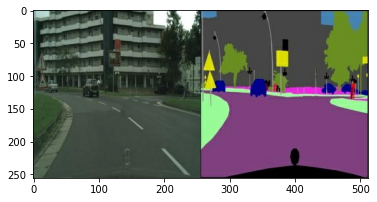

In [3]:
plt.figure()
plt.imshow(sample_image)

In [4]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

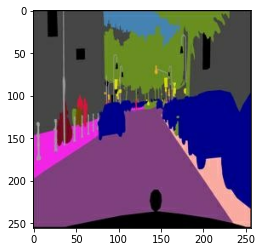

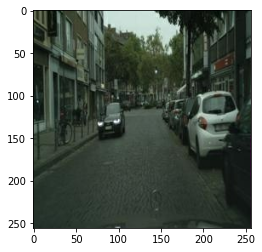

In [5]:
inp, re = load(str(data_path + 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

#### 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.

(어떠한 방법을 사용했는지 적어주세요.)

pix2pix 논문에 설명된 대로 훈련 세트를 전처리하기 위해 랜덤 지터링과 미러링을 적용해야 합니다.

다음과 같은 여러 함수를 정의합니다.

각 256 x 256 이미지의 크기를 더 큰 높이와 너비(286 x 286)로 조정합니다.
무작위로 다시 256 x 256으로 자릅니다.
이미지를 가로로 무작위로 뒤집습니다(예: 왼쪽에서 오른쪽으로 임의 미러링).
이미지를 [-1, 1] 범위로 정규화합니다.

In [6]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

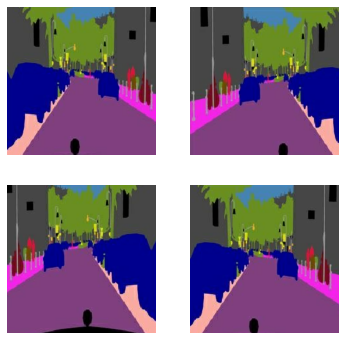

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

tf.data로 입력 파이프라인 구축하기

In [14]:
train_dataset = tf.data.Dataset.list_files(str(data_path + 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
try:
    test_dataset = tf.data.Dataset.list_files(str(data_path + 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(data_path +'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

##### 생성기 구축하기
pix2pix cGAN 생성기는 수정된 U-Net입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)로 구성됩니다. 이미지 분할 튜토리얼과 U-Net 프로젝트 웹사이트에서 자세한 내용을 알아볼 수 있습니다.

+ 인코의 각 블록은 다음과 같습니다: 컨볼루션 -> 배치 정규화 -> 누출이 있는 ReLU
+ 디코더의 각 블록은 다음과 같습니다: 전치된 컨볼루션 -> 배치 정규화 -> 드롭아웃(처음 3개 블록에 적용됨) -> ReLU
+ 인코더와 디코더 사이에는 건너뛰기 연결이 있습니다(U-Net에서와 같이).

다운샘플러(인코더) 정의:

In [16]:
OUTPUT_CHANNELS = 3

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


업샘플러(디코더) 정의:

In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


다운샘플러와 업샘플러로 생성기를 정의합니다.

In [21]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

생성기 모델 아키텍처 시각화:

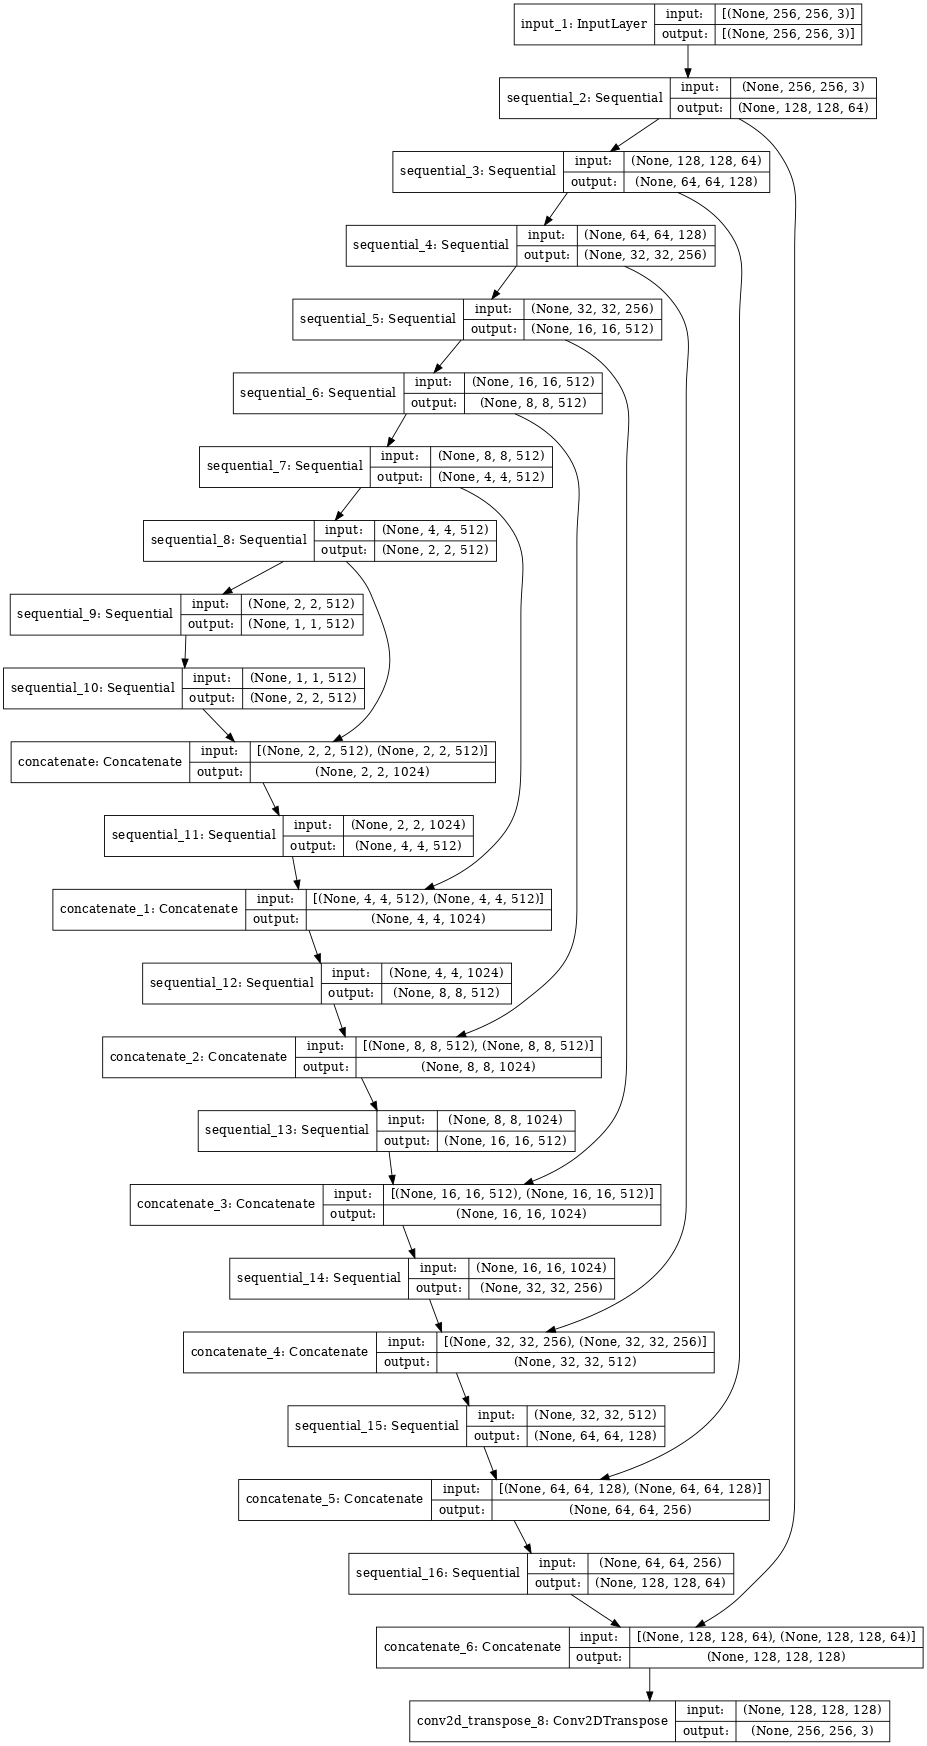

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


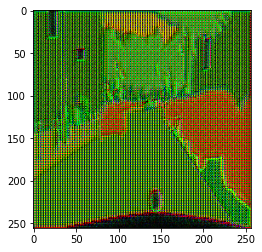

In [23]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

##### 생성기 손실 정의하기
GAN은 데이터에 적응하는 손실을 학습하는 반면 cGAN은 pix2pix 논문에 설명된 대로 네트워크 출력 및 대상 이미지와 다른 가능한 구조에 불이익을 주는 구조화된 손실을 학습합니다.

+ 생성기 손실은 생성된 이미지와 1로 구성된 배열의 시그모이드 교차 엔트로피 손실입니다.
+ pix2pix 논문에는 생성된 이미지와 대상 이미지 간의 MAE(평균 절대 오차)인 L1 손실도 언급되어 있습니다.
+ 이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.
+ 총 생성기 손실을 계산하는 공식은 gan_loss + LAMBDA * l1_loss이고 여기서 LAMBDA = 100입니다. 이 값은 논문 저자가 결정했습니다.

In [24]:
LAMBDA = 100

In [25]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

생성기의 훈련 절차
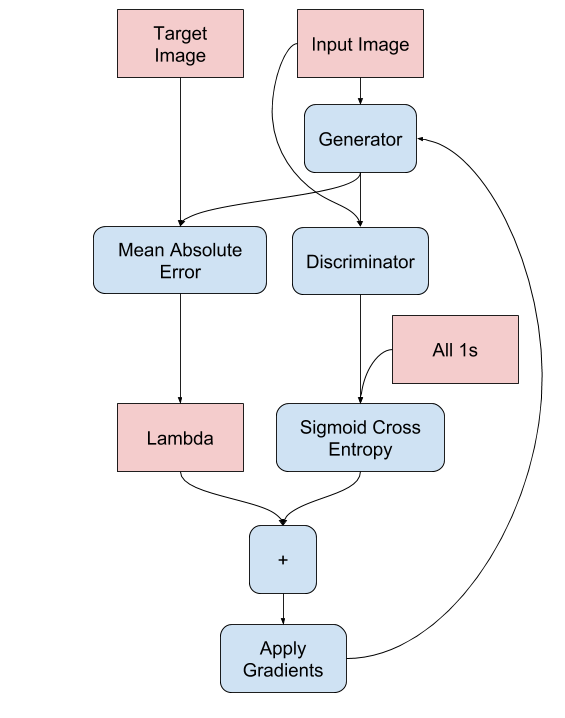

##### 판별자 구축하기
pix2pix cGAN의 판별자는 컨볼루셔널 PatchGAN 분류기로, pix2pix 논문{:.external}에 설명된 대로 각 이미지 패치가 실제인지 아닌지를 분류하려고 합니다.

+ 판별자의 각 블록은 다음과 같습니다: 컨볼루션 -> 배치 정규화 -> 누출이 있는 ReLU
+ 마지막 레이어 이후의 출력 형상은 ```(batch_size, 30, 30, 1)```입니다.
+ 출력의 각 ```30 x 30``` 이미지 패치는 입력 이미지의 ```70 x 70 ```부분을 분류합니다.
+ 판별자는 2개의 입력을 수신합니다.
+ 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    + 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    + 가짜로 분류해야 하는 입력 이미지와 생성된 이미지(생성기의 출력)
    + ```tf.concat([inp, tar], axis=-1)```을 사용하여 이 2개의 입력을 함께 연결
    
판별자를 정의하겠습니다.

In [27]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

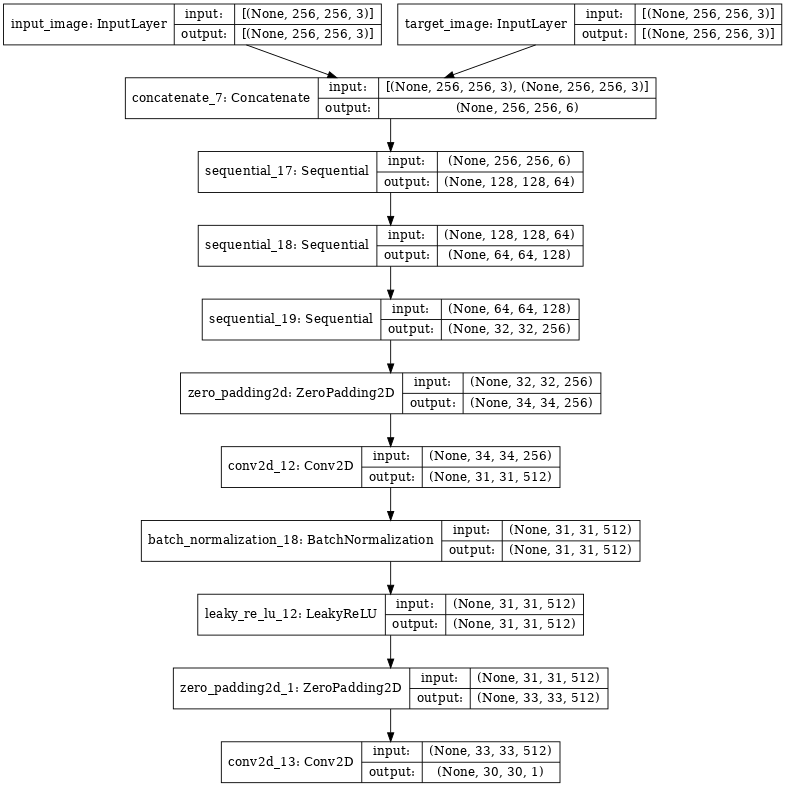

In [28]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

판별자 테스트:

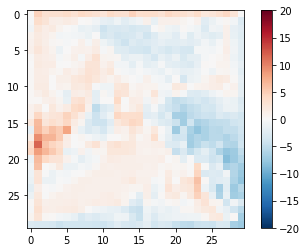

In [29]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

##### 판별자 손실 정의하기
+ discriminator_loss 함수는 진짜 이미지와 생성된 이미지의 두 입력을 받습니다.
+ real_loss는 진짜 이미지 및 1의 배열(실제 이미지이기 때문에)의 시그모이드 교차 엔트로피 손실입니다.
+ generated_loss는 생성된 이미지 및 0의 배열(가짜 이미지이기 때문에)의 시그모이드 교차 엔트로피 손실입니다.
+ total_loss는 real_loss와 generated_loss의 합계입니다

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

판별자의 훈련 절차는 다음과 같습니다.

아키텍처와 하이퍼파라미터에 대한 자세한 내용은 pix2pix 논문을 참조하세요. (https://arxiv.org/abs/1611.07004)
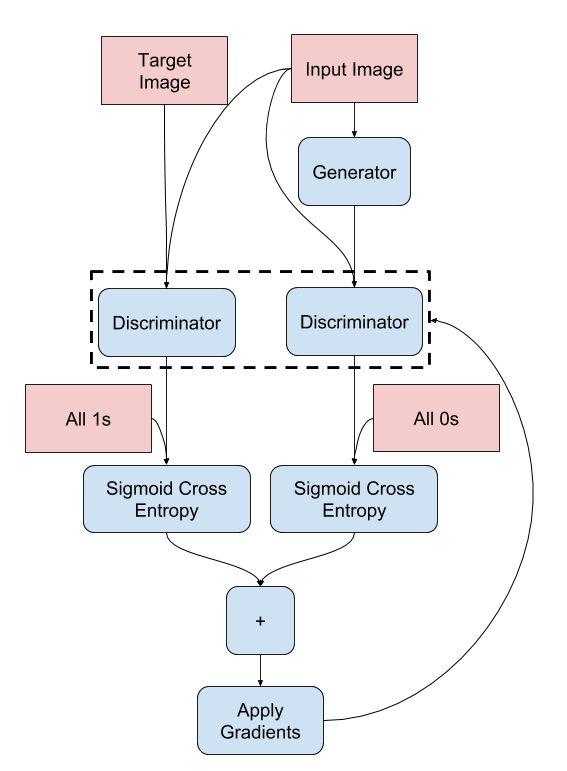

#### 옵티마이저 및 체크포인트 세이버 정의하기

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요. (맨아래 진행)

### 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

#### 이미지 생성하기
훈련 중에 일부 이미지를 플롯하는 함수를 작성합니다.

    +  테스트세트에서 생성기로 이미지를 전달합니다.
    + 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
    + 마지막 단계는 예측을 플로팅하는 것입니다. 자 보세요!
    
참고: 테스트 데이터세트에서 모델을 실행하는 동안 배치 통계를 원하기 때문에 여기서 ```training=True```는 의도적입니다. ```training=False```를 사용하면 훈련 데이터세트에서 학습된 누적 통계를 얻게 되는데, 이것은 원하는 것이 아닙니다.

In [33]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0],  prediction[0], tar[0]]
  title = ['Input Image', 'Predicted Image', 'Ground Truth']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

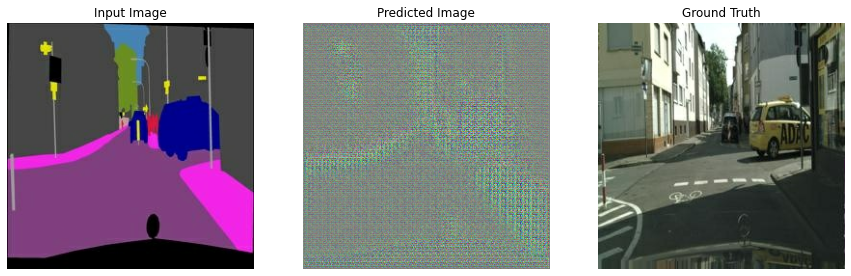

In [34]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### 5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

#### 훈련하기
+ 각 예제 입력에 대해 출력을 생성합니다.
+ 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
+ 다음으로 생성기와 판별자 손실을 계산합니다.
+ 그런 다음 생성기와 판별자 변수(입력) 모두에 대한 손실 기울기를 계산하고 이를 옵티마이저에 적용합니다.
+ 마지막으로 TensorBoard에 손실을 기록합니다

In [35]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)  
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
  if (step+1) % 10 == 0:  
    print(f"EPOCH[{step//epoch_1_cnt}] - STEP[{step+1}] \
                        \gen_total_loss:{gen_total_loss} \
                        \nGenerator_loss:{gen_gan_loss} \
                        \nL1_loss:{gen_l1_loss} \
                        \nDiscriminator_loss:{disc_loss}", end="\n\n", flush=True)


실제 훈련 루프. 이 튜토리얼은 둘 이상의 데이터세트를 실행할 수 있고 데이터세트의 크기가 크게 다르기 때문에 훈련 루프는 epoch 대신 단계적으로 작동하도록 설정됩니다.

+ 스텝 수를 반복합니다.
+ 10개 스텝마다 점(.)을 인쇄합니다.
+ 1k 스텝마다: 디스플레이를 지우고 generate_images를 실행하여 진행 상황을 표시합니다.
+ 5k 스텝마다: 체크포인트를 저장합니다.

In [37]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)     

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

이 훈련 루프는 훈련 진행 상황을 모니터링하기 위해 TensorBoard에서 볼 수 있는 로그를 저장합니다.

로컬 머신에서 작업하는 경우 별도의 TensorBoard 프로세스를 시작합니다. 노트북에서 작업할 때는 TensorBoard로 모니터링하기 위한 교육을 시작하기 전에 뷰어를 실행하세요.

뷰어를 시작하려면 다음을 코드 셀에 붙여 넣습니다.

In [43]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


무슨 이유인가 안됨...

In [39]:
#epoch 계산
epoch_1_cnt = len(train_dataset)
total_step = 50000 # / 5
epoch =  total_step / epoch_1_cnt
print("epoch = ", epoch)

epoch =  50.0


마지막으로 훈련 루프를 실행합니다.

Time taken for 1000 steps: 91.63 sec



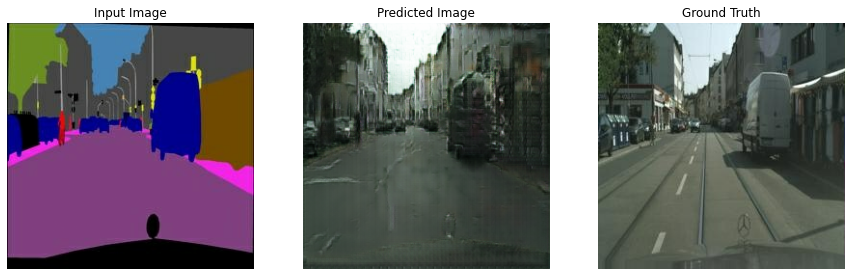

Step: 49k
....................................................................................................

In [40]:
fit(train_dataset, test_dataset, steps=total_step)

TensorBoard 결과를 공개적으로 공유하려면 다음을 코드 셀에 복사하여 TensorBoard.dev에 로그를 업로드할 수 있습니다.

```$ tensorboard dev upload --logdir {log_dir} ```

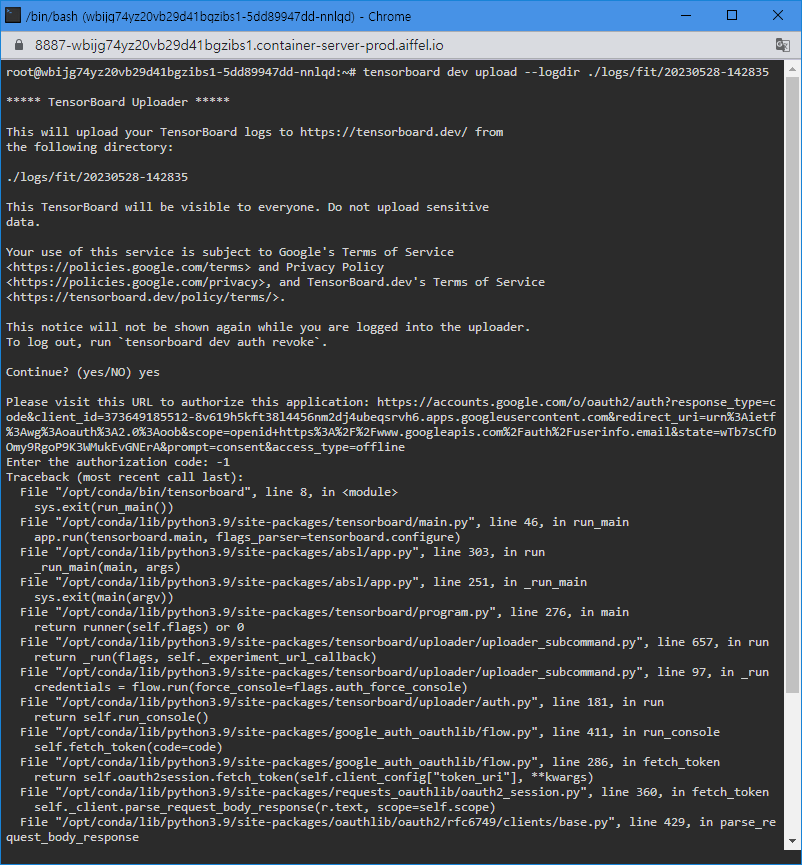

이걸 봐야하는데... 아래는 exmaple 그래프 입니다.

In [46]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     src="http//localhost:6008", # 이것도 안됨...
    width="100%",
    height="1000px")

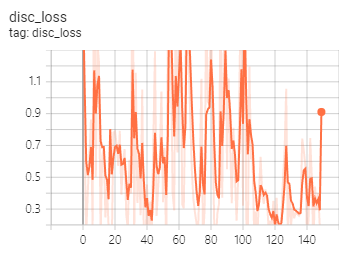

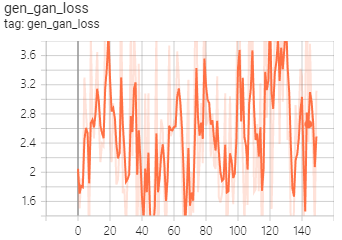

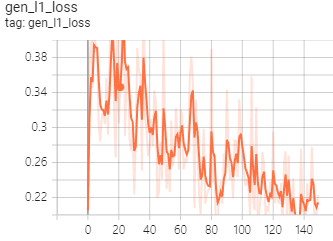

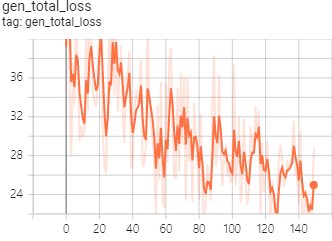

로그 해석은 단순 분류 또는 회귀 모델에 비해 GAN(또는 pix2pix와 같은 cGAN)을 훈련할 때 처리하기가 더 어렵습니다. 주목해야 할 사항:

+ 생성기 또는 판별자 모델 모두가 "이기"지 않는다는 것을 확인합니다. gen_gan_loss 또는 disc_loss가 매우 낮아지면 이 모델이 다른 모델을 지배하고 있어 결합된 모델을 성공적으로 훈련하지 못하고 있음을 나타내는 것입니다.
+ 값 log(2) = 0.69는 이러한 손실에 대한 좋은 기준점입니다. 이는 2의 퍼플렉시티를 나타내기 때문입니다. 판별자는 평균적으로 두 옵션에 대해 똑같이 불확실합니다.
+ disc_loss의 경우 0.69 미만의 값은 판별자가 실제 이미지와 생성된 이미지의 결합된 세트에서 무작위보다 더 효과적임을 의미합니다.
+ gen_gan_loss의 경우 0.69 미만의 값은 생성기가 판별자를 속이는 데 있어 무작위보다 더 효과적임을 의미합니다.
+ 훈련이 진행됨에 따라 gen_l1_loss가 내려갑니다.

### 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요. (맨아래 진행)

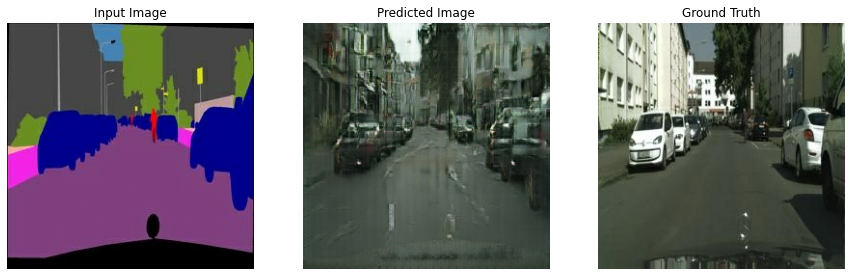

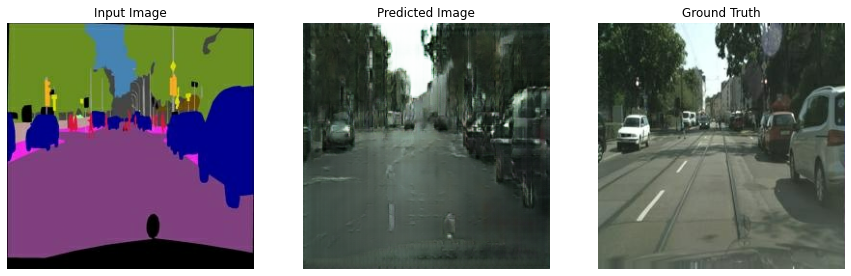

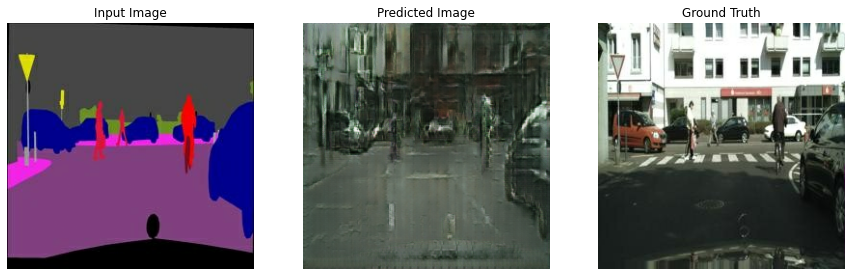

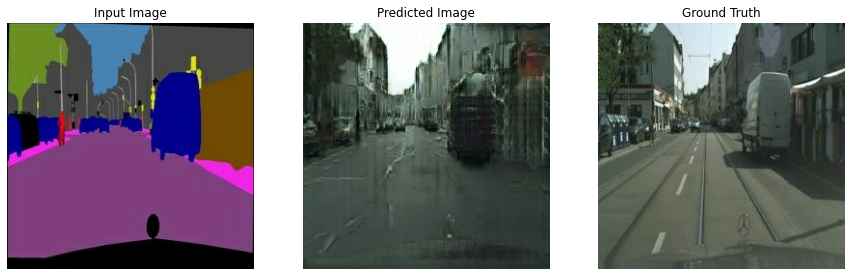

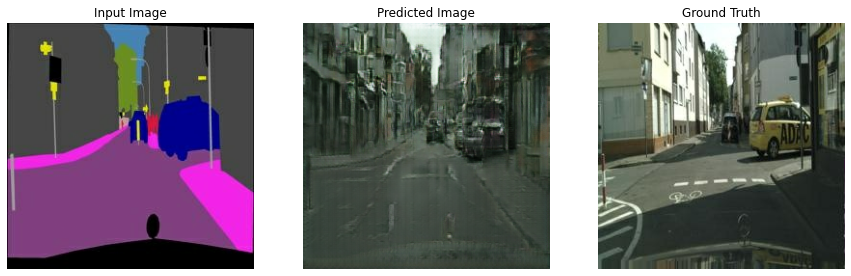

In [42]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)